# EDA

In [1]:
import os
import io
import cv2
from PIL import Image
import h5py
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing

#### > Create directory paths for the project

In [11]:
#General file paths
#projectDir = os.getcwd() + "/"
#parentDir = os.path.abspath(os.path.join(projectDir, os.pardir)) + "/"
dataPath = "C:/Users/marti/Documents/Martial/DEEP LEARNING PROJECT/isic-2024-challenge/"

#Metadata file paths
metaPath = dataPath + "train-metadata.csv"
#metaPath = dataPath + "sample-metadata.csv"

#Image file path
hdf5_file = dataPath + "train-image.hdf5"
#hdf5_file = dataPath + "sample-image.hdf5"

In [12]:
dataPath

'C:/Users/marti/Documents/Martial/DEEP LEARNING PROJECT/isic-2024-challenge/'

#### > Import training metadata

In [13]:
train_metadata = pd.read_csv(dataPath + "train-metadata.csv", sep=",")

C:\Users\marti\AppData\Local\Temp\ipykernel_23824\624185852.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata = pd.read_csv(dataPath + "train-metadata.csv", sep=",")


#### > Check metadata for one image

In [14]:
train_metadata[train_metadata["tbp_lv_color_std_mean"] == train_metadata["tbp_lv_color_std_mean"].max()]

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
201543,ISIC_5071401,0,IP_2331257,55.0,female,posterior torso,10.57,TBP tile: close-up,3D: XP,25.034564,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.889719


Examine a sample set of images

In [15]:
#normal, hairs1, hairs2, wrinkles1, wrinkles2, protrusions
trial_image_files = ["ISIC_0015670", "ISIC_0052213", "ISIC_0075726", "ISIC_0076172", "ISIC_8570031", "ISIC_5071401"]

#Filename and image id
file = dataPath + "train-image.hdf5"
#isic_id = "ISIC_0015670"

#Import hdf5 file and one image
trial_images = []
f = h5py.File(file, mode="r")
for isic_id in trial_image_files:
    image = np.array(
        Image.open(
            io.BytesIO(f[isic_id][()])
            )
        )
    trial_images.append(image)

#Find dimensions of the image (it is supposed to be 180 pixels if the image is 15mmx15mm)
print("Height of image in pixels =", len(trial_images[0])) #Image 0 - rows
print("Width of image in pixels =", len(trial_images[0][0])) #Image 0 - columns
#Show a line going through the middle of the image 1
trial_images[1][70]

Height of image in pixels = 139
Width of image in pixels = 139


array([[209, 167, 145],
       [205, 163, 141],
       [205, 163, 141],
       [211, 169, 147],
       [215, 173, 151],
       [211, 169, 147],
       [205, 163, 141],
       [202, 160, 138],
       [190, 148, 126],
       [193, 151, 129],
       [198, 156, 134],
       [201, 159, 137],
       [202, 160, 138],
       [199, 157, 135],
       [195, 153, 131],
       [192, 150, 128],
       [189, 147, 125],
       [194, 152, 130],
       [199, 157, 135],
       [201, 159, 137],
       [200, 158, 136],
       [200, 158, 136],
       [203, 161, 139],
       [206, 164, 142],
       [212, 170, 148],
       [208, 166, 144],
       [204, 162, 140],
       [204, 162, 140],
       [206, 164, 142],
       [210, 168, 146],
       [213, 171, 149],
       [214, 172, 150],
       [199, 157, 135],
       [202, 160, 138],
       [202, 161, 139],
       [199, 161, 138],
       [201, 165, 141],
       [201, 165, 141],
       [193, 159, 134],
       [182, 148, 123],
       [171, 137, 112],
       [196, 162

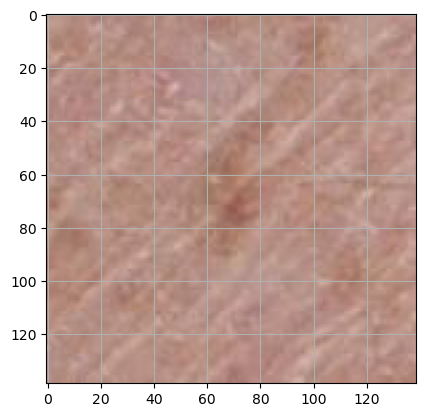

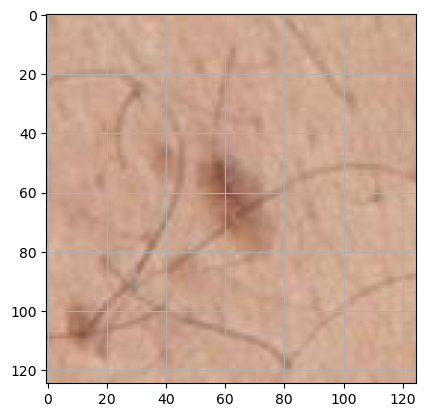

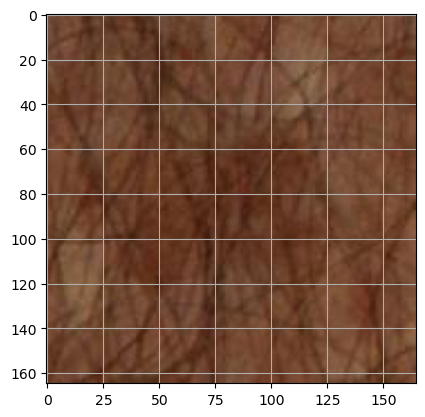

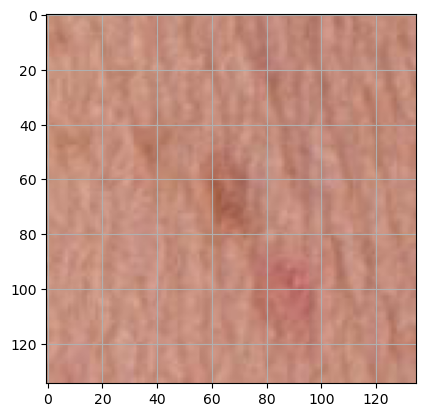

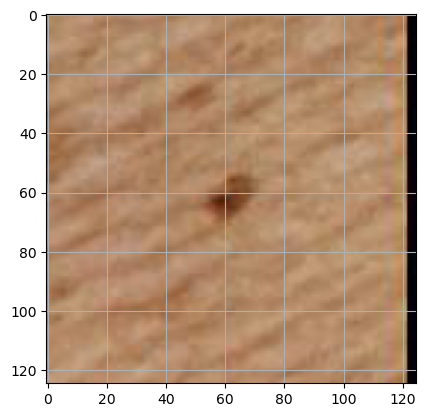

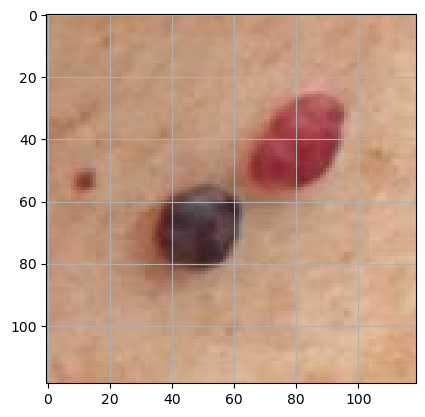

In [16]:
#Show the images
for image in trial_images:
    plt.imshow(image, interpolation=None)
    plt.grid(None)
    plt.show()

AJOUT DISTRIBUTION TAILLE ET INDICATEUR SUR LES IMAGES (CHEVEUX ET PEAUX FONCEES)

## III- TEST IMAGES PREPROCESSING AND AUGMENTATION

#### > Apply a hair removing algorithm (Dull Razor)

In [17]:
#Code taken and modified from https://github.com/BlueDokk/Dullrazor-algorithm.git
# Author: Javier Velasquez P.
# Date:Created on Tue Feb 18 11:42:26 2020
    
#DULL RAZOR (REMOVE HAIR)
#Provides a cleaned output image and the mean absolute difference between the images for each color in RGB
def hair_removal(image, crop_pixels = 10, dsply_images = False):

    height_pixels = len(image) #Image rows
    width_pixels = len(image[0]) #Image columns

    #Image cropping
    crop_pixels = 10
    height = [crop_pixels, height_pixels-crop_pixels]
    width = [crop_pixels, width_pixels-crop_pixels]
    img=image[height[0]:height[1],width[0]:width[1]]
    
    #Gray scale
    grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
    #Black hat filter
    kernel = cv2.getStructuringElement(1,(9,9)) 
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    #Gaussian filter
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
    #Binary thresholding (MASK)
    ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)
    #Replace pixels of the mask
    dst = cv2.inpaint(img,mask,6,cv2.INPAINT_TELEA)

    #Calculate the difference between initial an final images
    h = len(img)
    w = len(img[0])
    diff = np.absolute(img - dst)/(h*w)
    diff = np.sum(diff,axis=(0,1))

    #Display images
    if dsply_images:
        img_list = [image, img, grayScale, blackhat, mask, dst]
        for item in img_list:
            plt.imshow(item)
            plt.grid(None)
            plt.show()

    return dst, diff

#### > Apply image sharpening

In [19]:

#Sharpen image (subract a blurred image from the inital image, applying weights)
def sharpen(image, shrp_weight = 0.5):
    blur = cv2.GaussianBlur(image, (0, 0), 2)
    shrp = cv2.addWeighted(image, 1 + shrp_weight, blur, -shrp_weight, 0)
    return shrp
    

In [18]:
img_num = 4

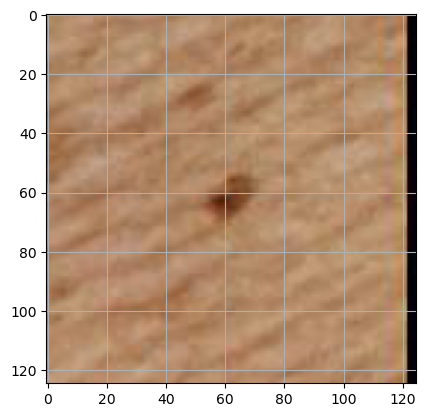

In [20]:
plt.imshow(trial_images[img_num], interpolation=None)
plt.grid(None)
plt.show()

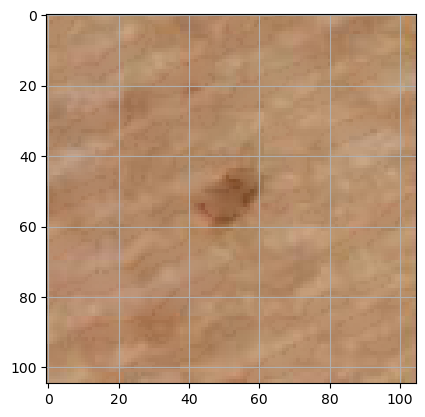

[40.57986395 40.34956916 40.37578231]


In [21]:
#Test the hair removing algorithm
img, diff = hair_removal(trial_images[img_num])
plt.imshow(img)
plt.grid(None)
plt.show()
print(diff)

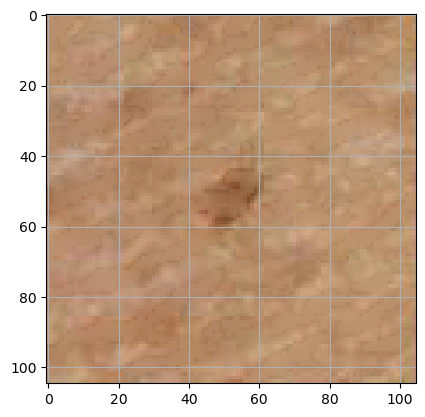

[62.16907029 61.96126984 61.81170068]


In [22]:
#Test the hair removing algorithm  with high sharpening
img, diff = hair_removal(sharpen(trial_images[img_num], shrp_weight=0.5))
plt.imshow(img)
plt.grid(None)
plt.show()
print(diff)

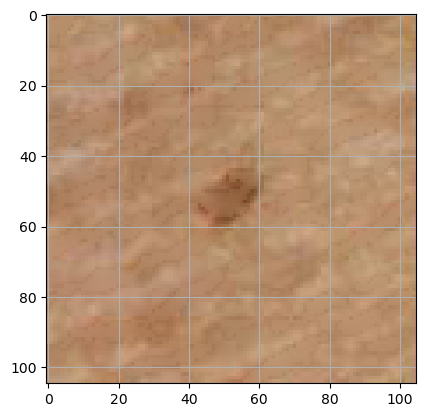

[50.21632653 49.96226757 49.84145125]


In [23]:
#Test the hair removing algorithm  with low sharpening
img, diff = hair_removal(sharpen(trial_images[img_num], shrp_weight=0.2))
plt.imshow(img)
plt.grid(None)
plt.show()
print(diff)

## IV- METADATA

#### Create a display function permitting easy adjustment of max_rows and max_columns options (Pandas dataframes)

In [24]:
#A pandas dataframe must be the input
#head_tail: 0 = neither, 1 = head, 2 = tail
#Enter "None" (without quotes) as the value of nb_rows or nb_cols if the standard limit should be applied (60 rows & 20 columns)
def display_more(df, head_tail = 0, nb_rows=60, nb_cols= pd.options.display.max_columns):
    with pd.option_context('display.max_rows', nb_rows, 'display.max_columns', nb_cols):
        if head_tail == 1:
            display(df.head())
        elif head_tail == 2:
            display(df.tail())
        else:
            display(df)

#### > Examine the metadata

In [25]:
#Display the first lines
display_more(train_metadata, head_tail = 1, nb_cols=55)
#Display basic statistical data
display_more(train_metadata.describe(), nb_cols=55)

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.00000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,Right Leg - Upper,Right Leg,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.00000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,Head & Neck,Head & Neck,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,Memorial Sloan Kettering Cancer Center,CC-BY,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,62.909730,53.961180,61.670520,3.265153,24.184620,0.00000,5.447655,4.485044,-7.709336,9.092376,6.290359,0.932147,Torso Back Top Third,Torso Back,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,12.164757,21.448144,21.121356,25.746200,24.374023,56.414429,60.060388,18.649518,23.314841,6.079940,14.889242,0.51452,2.077572,0.326788,-4.665323,4.783413,6.400196,0.654458,Torso Front Top Half,Torso Front,2.481328,2.198945e+01,1.975874,1.771705,9.514499,0.66469,1.258541,1.573733,0.209581,130,-141.024780,1442.185791,58.359802,ACEMID MIA,CC-0,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,20.057470,26.464900,25.710460,36.217980,32.608740,46.946070,52.041180,46.276310,54.855740,2.101708,19.902560,0.00000,4.668053,0.754434,-8.579431,9.148495,6.531302,0.946448,Torso Front Top Half,Torso Front,0.929916,1.378832e-03,3.658854,0.000000,6.467562,0.00000,2.085409,2.480509,0.313433,20,-72.315640,1488.720000,21.428960,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


,target,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,mel_thick_mm,tbp_lv_dnn_lesion_confidence
count,401059.000000,398261.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,401059.000000,63.000000,4.010590e+05
mean,0.000980,58.012986,3.930827,19.974007,14.919247,28.281706,26.913015,34.786341,30.921279,54.653689,60.996869,42.289976,51.199529,8.539975,19.084517,1.070408,5.054760,1.368691,-8.909552,9.455766,7.538922,0.741238,2.539773,38.520265,3.451523,3.091590,11.878891,1.016459,2.715190,2.238605,0.306823,86.332073,-3.091862,1039.598221,55.823389,0.670952,9.716220e+01
std,0.031288,13.596165,1.743068,3.999489,3.529384,5.278676,4.482994,5.708469,4.829345,5.520849,5.631909,10.864572,12.100527,9.679312,5.357863,0.762918,2.642928,2.215871,3.463362,3.466703,2.404951,0.143857,1.173169,41.480936,1.724557,2.044813,5.919302,0.734631,1.738165,0.623884,0.125038,52.559511,197.257995,409.819653,87.968245,0.792798,8.995782e+00
min,0.000000,5.000000,1.000000,-2.487115,-9.080269,-0.730989,9.237066,3.054228,11.846520,-1.574164,28.436490,4.223007,17.702260,0.431601,10.761634,0.000000,-13.819850,-18.088106,-38.756140,2.952675,3.001138,0.027667,0.273973,0.000000,0.589426,0.000000,2.579237,0.000000,0.268160,0.636247,0.052034,0.000000,-624.870728,-1052.134000,-291.890442,0.200000,1.261082e-16
25%,0.000000,50.000000,2.840000,17.330821,12.469740,24.704372,23.848125,31.003148,27.658285,51.566273,57.297630,34.303345,42.274506,4.109589,15.426205,0.574909,3.413108,0.111030,-10.675470,6.952377,5.748160,0.656627,1.812707,0.109819,2.143836,1.728774,8.338364,0.563891,1.456570,1.834745,0.211429,40.000000,-147.022125,746.519673,-8.962647,0.300000,9.966882e+01
50%,0.000000,60.000000,3.370000,19.801910,14.713930,28.171570,26.701704,34.822580,30.804893,55.035632,61.109173,42.343770,51.425557,5.685870,17.423950,0.931402,4.643926,1.593945,-8.132223,8.699932,6.946320,0.768215,2.265201,14.408514,2.996933,2.764664,10.015440,0.902281,2.186693,2.149758,0.282297,90.000000,-5.747253,1172.803000,67.957947,0.400000,9.999459e+01
75%,0.000000,70.000000,4.380000,22.304628,17.137175,31.637429,29.679913,38.430298,33.963868,58.298184,64.905025,50.405051,60.495607,9.119910,21.011340,1.412154,6.274246,2.850638,-6.397103,11.243486,8.748403,0.853175,2.905918,87.791395,4.358399,4.120246,13.209100,1.334523,3.474565,2.531443,0.382022,130.000000,140.474835,1342.131540,126.611567,0.600000,9.999996e+01
max,1.000000,85.000000,28.400000,48.189610,37.021680,54.306900,48.372700,58.765170,54.305290,105.875784,130.983300,87.548888,98.588250,334.152700,87.205340,9.952932,32.137590,12.643930,-1.590631,39.197720,30.487456,0.974960,18.387900,100.000000,10.000000,10.000000,102.493900,11.491140,17.563650,25.534791,0.977055,175.000000,614.471700,1887.766846,319.407000,5.000000,1.000000e+02


In [26]:
#Display other summary data (NA counts, data types)
metadata_summary = pd.DataFrame(train_metadata.isna().sum(), columns=["NA_occurrences"])
metadata_summary["data_type"] = train_metadata.dtypes
temp = train_metadata.describe().transpose().drop(columns=["count","std"])
metadata_summary = metadata_summary.join(temp)
display_more(metadata_summary, nb_rows=100)

,NA_occurrences,data_type,mean,min,25%,50%,75%,max
isic_id,0,object,NaN,NaN,NaN,NaN,NaN,NaN
target,0,int64,0.000980,0.000000e+00,0.000000,0.000000,0.000000,1.000000
patient_id,0,object,NaN,NaN,NaN,NaN,NaN,NaN
age_approx,2798,float64,58.012986,5.000000e+00,50.000000,60.000000,70.000000,85.000000
sex,11517,object,NaN,NaN,NaN,NaN,NaN,NaN
anatom_site_general,5756,object,NaN,NaN,NaN,NaN,NaN,NaN
clin_size_long_diam_mm,0,float64,3.930827,1.000000e+00,2.840000,3.370000,4.380000,28.400000
image_type,0,object,NaN,NaN,NaN,NaN,NaN,NaN
tbp_tile_type,0,object,NaN,NaN,NaN,NaN,NaN,NaN
tbp_lv_A,0,float64,19.974007,-2.487115e+00,17.330821,19.801910,22.304628,48.189610


#### > Look at the data per patient

In [28]:
# Check for duplicates in the 'isic_id' column
duplicates = train_metadata.duplicated(subset='patient_id', keep=False)
duplicate_rows = train_metadata[duplicates]
 
# Count the number of duplicate rows
num_duplicates = duplicate_rows.shape[0]
 
# Display the results
print(f"Number of duplicate rows based on 'patient_id': {num_duplicates}")

Number of duplicate rows based on 'patient_id': 401054


In [29]:
#Display 10 first duplicate
print(duplicate_rows.head(10))

        isic_id  target  patient_id  age_approx     sex anatom_site_general  \
0  ISIC_0015670       0  IP_1235828        60.0    male     lower extremity   
1  ISIC_0015845       0  IP_8170065        60.0    male           head/neck   
2  ISIC_0015864       0  IP_6724798        60.0    male     posterior torso   
3  ISIC_0015902       0  IP_4111386        65.0    male      anterior torso   
4  ISIC_0024200       0  IP_8313778        55.0    male      anterior torso   
5  ISIC_0035502       0  IP_3026693        75.0  female           head/neck   
6  ISIC_0051648       0  IP_0218255        65.0    male     upper extremity   
7  ISIC_0051665       0  IP_7734648        50.0    male     posterior torso   
8  ISIC_0051710       0  IP_1307115        50.0    male      anterior torso   
9  ISIC_0051758       0  IP_2180091        60.0  female     upper extremity   

   clin_size_long_diam_mm          image_type tbp_tile_type   tbp_lv_A  ...  \
0                    3.04  TBP tile: close-up     3

In [30]:
# Example of duplicate
# Specify the patient IDs to filter
patient_ids = ['IP_1235828', 'IP_8170065']
 
# Filter the DataFrame for the specified patient IDs
is_patient_id = train_metadata['patient_id'].isin(patient_ids)
filtered_data = train_metadata[is_patient_id]
print(filtered_data)

             isic_id  target  patient_id  age_approx   sex  \
0       ISIC_0015670       0  IP_1235828        60.0  male   
1       ISIC_0015845       0  IP_8170065        60.0  male   
131     ISIC_0076432       0  IP_1235828        60.0  male   
2072    ISIC_0124587       0  IP_1235828        60.0  male   
2332    ISIC_0130299       0  IP_1235828        60.0  male   
...              ...     ...         ...         ...   ...   
397840  ISIC_9919878       0  IP_1235828        60.0  male   
398195  ISIC_9929307       0  IP_1235828        60.0  male   
398396  ISIC_9934582       0  IP_1235828        60.0  male   
399576  ISIC_9963797       0  IP_1235828        60.0  male   
400809  ISIC_9994034       0  IP_8170065        60.0  male   

       anatom_site_general  clin_size_long_diam_mm          image_type  \
0          lower extremity                    3.04  TBP tile: close-up   
1                head/neck                    1.10  TBP tile: close-up   
131        posterior torso       

In [31]:
#Number of unique patient
# Drop duplicate rows based on 'patient_id'
unique_patients = train_metadata.drop_duplicates(subset='patient_id')
unique_patients_count=unique_patients.value_counts()
# Print the result
print(f"Number of unique patient: {unique_patients_count}")
 
 
#Number of picture by patient
# Count the number of photos (isic_id) for each patient (patient_id)
photo_counts = train_metadata.groupby('patient_id').size()
 
# Calculate the average number of photos per patient
average_photos_per_patient = photo_counts.mean()
 
# Print the result
print(f"Average number of photos per patient: {average_photos_per_patient:.2f}")

Number of unique patient: Series([], Name: count, dtype: int64)
Average number of photos per patient: 384.89


#### > NA focus

In [32]:
#Focus on NA for varaible age, sex, anatom
# Select columns 3-5 +ptient_Id
cols_2_to_5 = train_metadata.iloc[:, 2:6]
 
 
# Initialize a dictionary to store results
results = {}
 
# Loop through each column of interest
for col in cols_2_to_5:
    # Identify rows with NA values in the column
    na_rows = train_metadata[train_metadata[col].isna()]
    # Get the patient IDs associated with these rows
    patient_ids_with_na = na_rows['patient_id'].unique()
    # Check if these patient IDs have values in the same column
    filtered_data_patient_na = train_metadata[train_metadata['patient_id'].isin(patient_ids_with_na)]
    non_na_rows = filtered_data_patient_na.dropna(subset=[col])
    # Count the number of rows for these patient IDs where the column has data
    count_non_na_rows = len(non_na_rows)
    # Store the results
    results[col] = {
        'number_of_na': len(na_rows),
        'number_of_unique_patient_ids_with_na': len(patient_ids_with_na),
        'number_of_rows_with_data': count_non_na_rows
    }
 
# Print the results
for col, res in results.items():
    print(f"Column: {col}")
    print(f"  Number of NA values: {res['number_of_na']}")
    print(f"  Number of unique patient IDs with NA: {res['number_of_unique_patient_ids_with_na']}")
    print(f"  Number of rows with data for these patient IDs: {res['number_of_rows_with_data']}")
    print()


Column: patient_id
  Number of NA values: 0
  Number of unique patient IDs with NA: 0
  Number of rows with data for these patient IDs: 0

Column: age_approx
  Number of NA values: 2798
  Number of unique patient IDs with NA: 13
  Number of rows with data for these patient IDs: 0

Column: sex
  Number of NA values: 11517
  Number of unique patient IDs with NA: 33
  Number of rows with data for these patient IDs: 0

Column: anatom_site_general
  Number of NA values: 5756
  Number of unique patient IDs with NA: 35
  Number of rows with data for these patient IDs: 14977



#### > Histograms

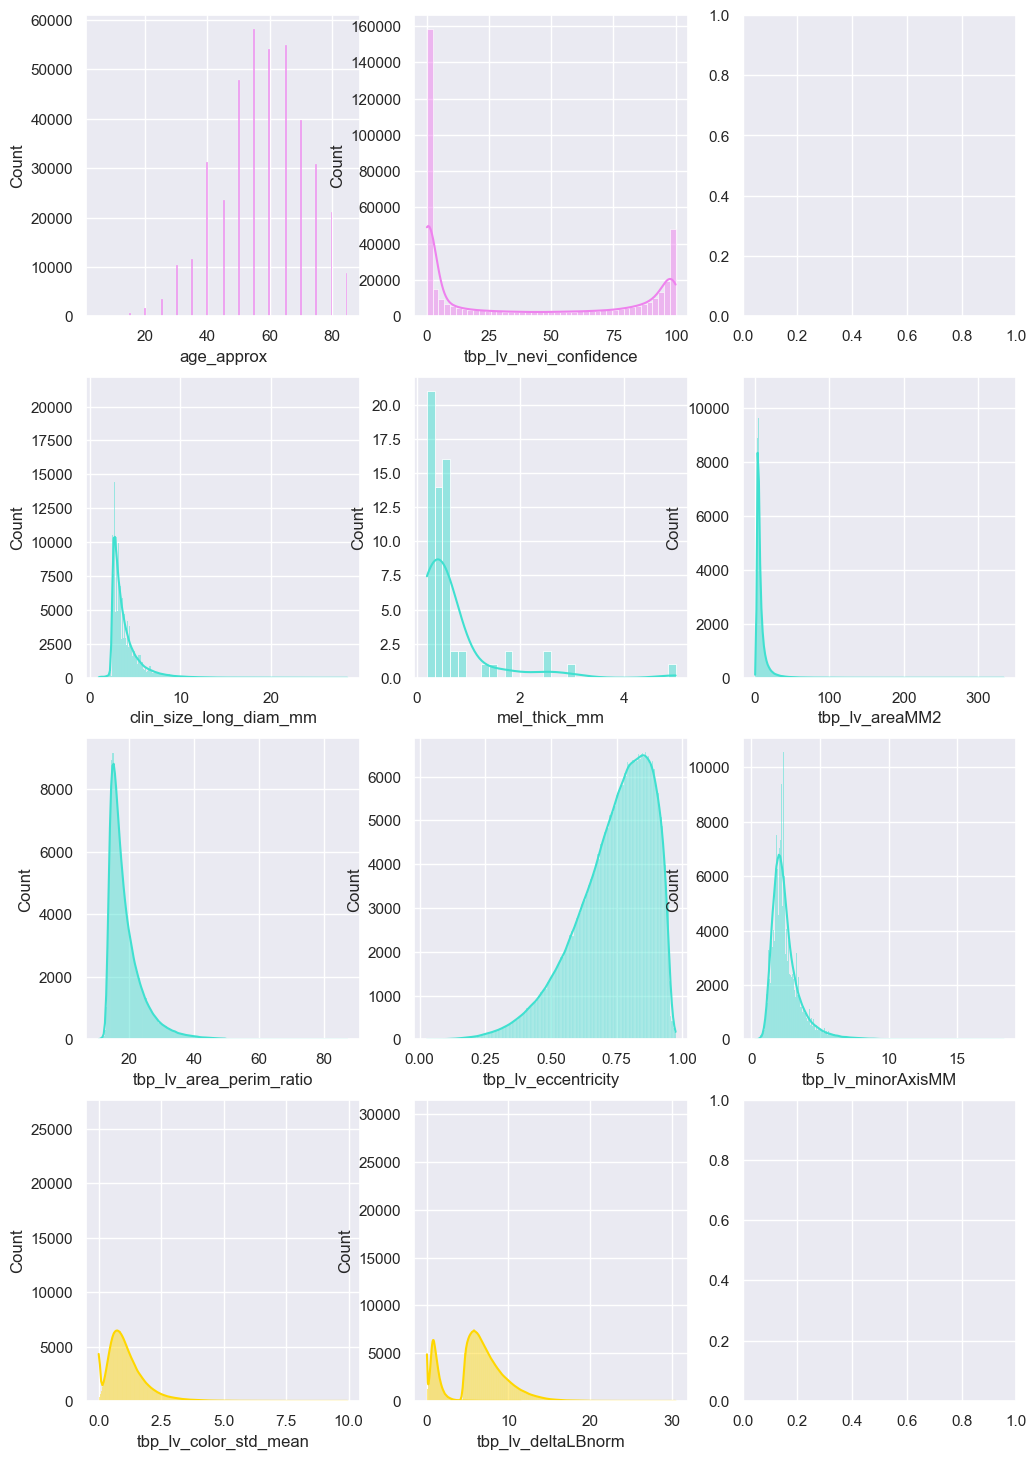

In [27]:
#Define dataframe to plot
df = train_metadata
#Set Seaborn theme
sns.set_theme(style="darkgrid")
#Establish multi-plot dimensions
fig, pos = plt.subplots(nrows=4, ncols=3, figsize=(12, 18))
###--- Create plots ---###
#General Data
sns.histplot(data=df, x="age_approx", kde=False, color="violet", ax=pos[0, 0]) #Age of patient
sns.histplot(data=df, x="tbp_lv_nevi_confidence", kde=True, color="violet", ax=pos[0, 1]) #probability that the lesion is a nevus
#Shape and size data 1
sns.histplot(data=df, x="clin_size_long_diam_mm", kde=True, color="turquoise", ax=pos[1, 0]) #Maximum diameter of the lesion (mm)
sns.histplot(data=df, x="mel_thick_mm", kde=True, color="turquoise", ax=pos[1, 1]) #Thickness in depth of melanoma invasion (*only in training data)
sns.histplot(data=df, x="tbp_lv_areaMM2", kde=True, color="turquoise", ax=pos[1, 2]) #Area of lesion (mm^2)
#Shape and size data 2
sns.histplot(data=df, x="tbp_lv_area_perim_ratio", kde=True, color="turquoise", ax=pos[2, 0]) #Border jaggedness, the ratio between lesions perimeter and area
sns.histplot(data=df, x="tbp_lv_eccentricity", kde=True, color="turquoise", ax=pos[2, 1]) #Eccentricity of lesion
sns.histplot(data=df, x="tbp_lv_minorAxisMM", kde=True, color="turquoise", ax=pos[2, 2]) #Smallest lesion diameter (mm)
#Color data
sns.histplot(data=df, x="tbp_lv_color_std_mean", kde=True, color="gold", ax=pos[3, 0]) #Color irregularity
sns.histplot(data=df, x="tbp_lv_deltaLBnorm", kde=True, color="gold", ax=pos[3, 1]) #Contrast between the lesion and its immediate surrounding skin
sns.histplot(data=df, x="tbp_lv_radial_color_std_max", kde=True, color="gold", ax=pos[3, 1]) #Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion

plt.show()

#### > AGE

<Figure size 1200x800 with 0 Axes>

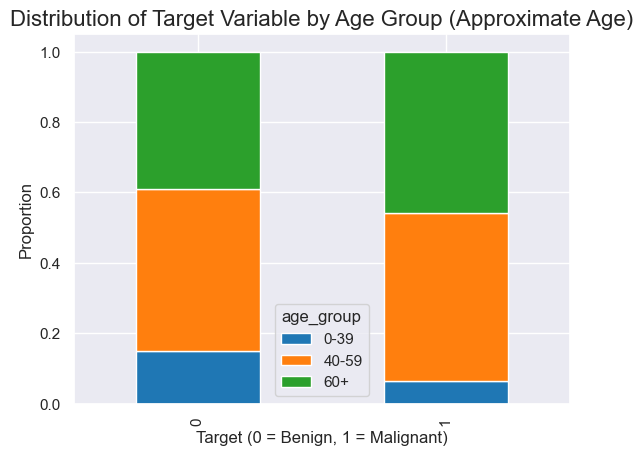

In [34]:
# Set the size of the plot
plt.figure(figsize=(12, 8))

# Create age groups for clearer grouping
bins = [0,40, 60, 100]  
labels = ['0-39', '40-59', '60+']
train_metadata['age_group'] = pd.cut(train_metadata['age_approx'], bins=bins, labels=labels)

# Normalize the counts of each age group by target
age_group_freq = train_metadata.groupby('target')['age_group'].value_counts(normalize=True).unstack()

# plot the distribution of target by age group
age_group_freq.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e', '#2ca02c'])


# Set x and y axis labels
plt.xlabel('Target (0 = Benign, 1 = Malignant)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)

# Set the title of the plot
plt.title("Distribution of Target Variable by Age Group (Approximate Age)", fontsize=16)
plt.grid(True)

# Display plot
plt.show()


    The older age groups ("40-59", "60-79", "80+") tend to have more cases. This could indicate that as age increases, there is a higher frequency of cases.
    The age group "60-79" shows some notable contribution to malignant cases, suggesting that this age group may be at a higher risk



## Look at the data that is of type OBJECT

#### General data

#### > SEX

In [35]:
#sex: sex of the patient
print(train_metadata["sex"].value_counts())

sex
male      265546
female    123996
Name: count, dtype: int64


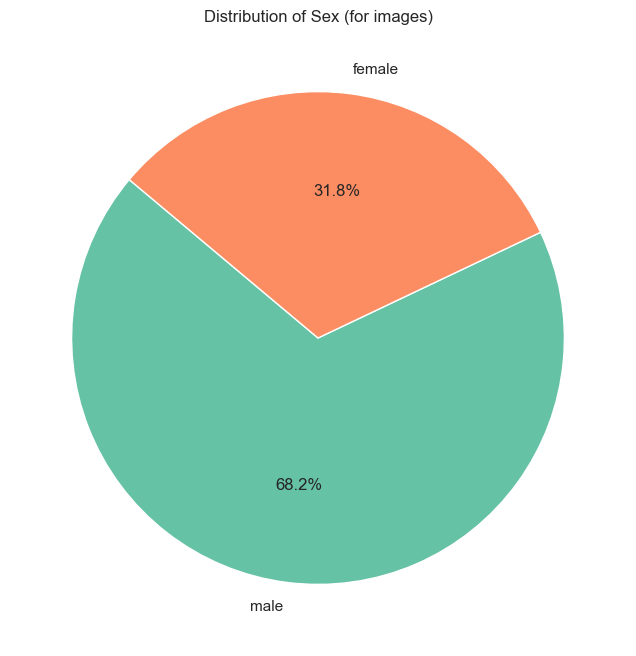

In [39]:
# Plot the distribution of 'sex' for images
sex_counts = train_metadata['sex'].value_counts()
 
# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
plt.title("Distribution of Sex (for images)")
plt.show()

<Figure size 1200x800 with 0 Axes>

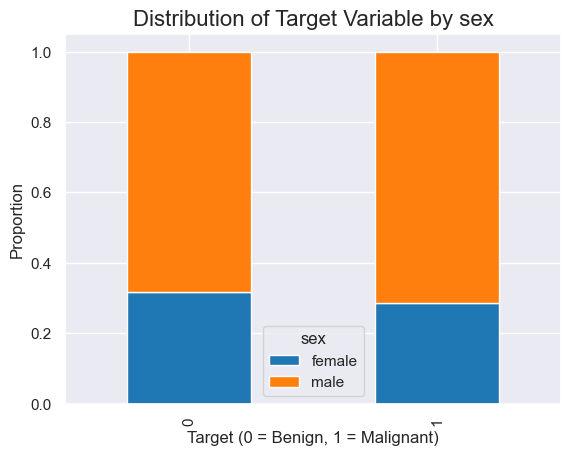

In [36]:
# Set a larger figure size for better visibility
plt.figure(figsize=(12, 8))


# Normalize the counts of each age group by target
sex_group_freq = train_metadata.groupby('target')['sex'].value_counts(normalize=True).unstack()

# plot the distribution of target by age group
sex_group_freq.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e'])


# Set x and y axis labels
plt.xlabel('Target (0 = Benign, 1 = Malignant)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)

# Set the title of the plot
plt.title("Distribution of Target Variable by sex", fontsize=16)
plt.grid(True)

# Display plot
plt.show()

Based on the plot, we can say that the difference in the distribution of benign and malignant cases between males and females is not extremely large. While there are more males in both benign and malignant categories, the difference is not substantial. Both sexes show a higher occurrence of benign cases, and the proportion of malignant cases seems similar for both.


#### > Anatomical Site

<Figure size 1200x800 with 0 Axes>

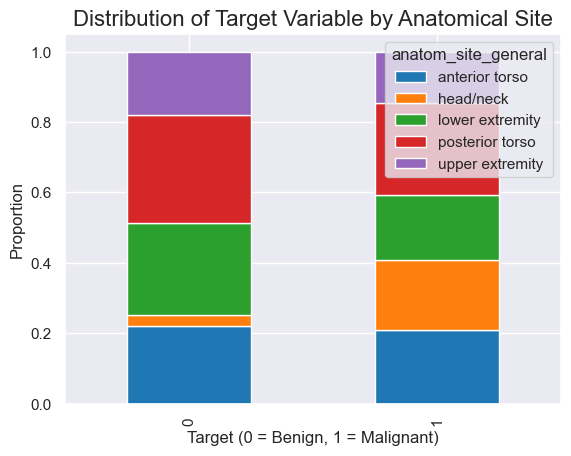

In [41]:
# Set a larger figure size for better visibility
plt.figure(figsize=(12, 8))


# Normalize the counts of each age group by target
sex_group_freq = train_metadata.groupby('target')['anatom_site_general'].value_counts(normalize=True).unstack()

# plot the distribution of target by age group
sex_group_freq.plot(kind='bar', stacked=True, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])


# Set x and y axis labels
plt.xlabel('Target (0 = Benign, 1 = Malignant)', fontsize=12)
plt.ylabel('Proportion', fontsize=12)

# Set the title of the plot
plt.title("Distribution of Target Variable by Anatomical Site", fontsize=16)
plt.grid(True)

# Display plot
plt.show()


Posterior torso seems to have a relatively higher number of malignant cases, whereas lower extremity and anterior torso show a more balanced distribution between benign and malignant cases. Head/neck stands out for having more malignant cases despite the lower overall count, which might suggest a need for focused attention in this region. Overall, this distribution suggests certain anatomical sites, like the posterior torso and head/neck, may have higher malign

#### > Other features

In [18]:
#image_type: Structured field of the ISIC Archive for image type
print(train_metadata["image_type"].value_counts())

image_type
TBP tile: close-up    401059
Name: count, dtype: int64


In [19]:
#tbp_tile_type: Lighting modality of the 3D TBP source image
print(train_metadata["tbp_tile_type"].value_counts())

tbp_tile_type
3D: XP       285903
3D: white    115156
Name: count, dtype: int64


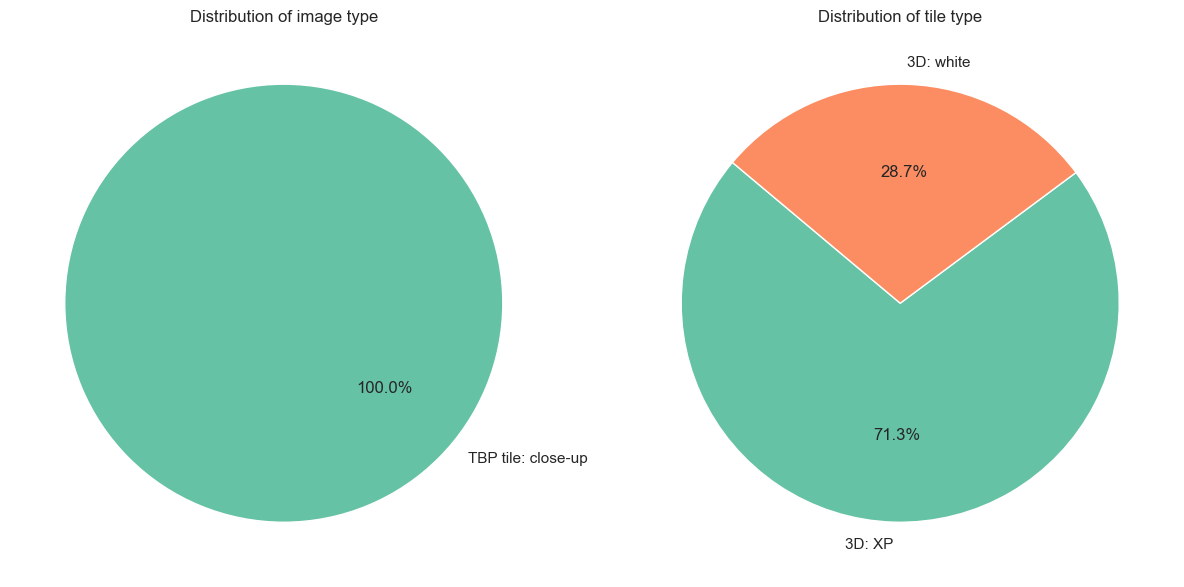

In [42]:
image_type_counts = train_metadata['image_type'].value_counts()
tile_type_counts = train_metadata['tbp_tile_type'].value_counts()
 
# Set up subplots: 2 rows, 2 columns
fig, pos = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
 
# Plot the first pie chart
pos[0].pie(image_type_counts, labels=image_type_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
pos[0].set_title("Distribution of image type")
 
# Plot the second pie chart
pos[1].pie(tile_type_counts, labels=tile_type_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
pos[1].set_title("Distribution of tile type")
 
 
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [43]:
#lesion_id: Unique lesion identifier. Present in lesions that were manually tagged as a lesion of interest
train_metadata["lesion_id"].dropna()

1         IL_6727506
49        IL_3854228
76        IL_9898853
93        IL_2988728
107       IL_6219432
             ...    
400997    IL_0041380
401019    IL_3334800
401028    IL_9124999
401054    IL_9520694
401056    IL_9852274
Name: lesion_id, Length: 22058, dtype: object

#### Lesion type

In [44]:
#iddx_full: First level lesion diagnosis
print(train_metadata["iddx_full"].value_counts(), "\n")
print("NAs in data:", train_metadata["iddx_full"].isna().sum())

iddx_full
Benign                                                                                                                                                           399991
Benign::Benign melanocytic proliferations::Nevus::Nevus, Atypical, Dysplastic, or Clark                                                                             228
Benign::Benign melanocytic proliferations::Nevus                                                                                                                    141
Malignant::Malignant adnexal epithelial proliferations - Follicular::Basal cell carcinoma::Basal cell carcinoma, Nodular                                             98
Indeterminate::Indeterminate melanocytic proliferations::Atypical melanocytic neoplasm                                                                               64
Benign::Benign epidermal proliferations::Seborrheic keratosis                                                                                         

In [45]:
#target
print(train_metadata["target"].value_counts(), "\n")
print("NAs in data:", train_metadata["target"].isna().sum())

target
0    400666
1       393
Name: count, dtype: int64 

NAs in data: 0


In [46]:
#iddx_1: First level lesion diagnosis
print(train_metadata["iddx_1"].value_counts(), "\n")
print("NAs in data:", train_metadata["iddx_1"].isna().sum())

iddx_1
Benign           400552
Malignant           393
Indeterminate       114
Name: count, dtype: int64 

NAs in data: 0


In [47]:
#iddx_2: First level lesion diagnosis
print(train_metadata["iddx_2"].value_counts(), "\n")
print("NAs in data:", train_metadata["iddx_2"].isna().sum())

iddx_2
Benign melanocytic proliferations                                 443
Malignant adnexal epithelial proliferations - Follicular          163
Malignant melanocytic proliferations (Melanoma)                   157
Benign epidermal proliferations                                    83
Indeterminate melanocytic proliferations                           75
Malignant epidermal proliferations                                 73
Indeterminate epidermal proliferations                             39
Benign soft tissue proliferations - Fibro-histiocytic              15
Inflammatory or infectious diseases                                 7
Flat melanotic pigmentations - not melanocytic nevus                5
Benign soft tissue proliferations - Vascular                        3
Cysts                                                               2
Benign adnexal epithelial proliferations - Follicular               2
Benign adnexal epithelial proliferations - Apocrine or Eccrine      1
Name: count, 

In [48]:
#iddx_3: First level lesion diagnosis
print(train_metadata["iddx_3"].value_counts(), "\n")
print("NAs in data:", train_metadata["iddx_3"].isna().sum())

iddx_3
Nevus                                                 443
Basal cell carcinoma                                  163
Melanoma in situ                                       80
Atypical melanocytic neoplasm                          64
Melanoma Invasive                                      63
Seborrheic keratosis                                   57
Squamous cell carcinoma in situ                        49
Solar or actinic keratosis                             39
Squamous cell carcinoma, Invasive                      22
Melanoma, NOS                                          13
Solar lentigo                                          12
Dermatofibroma                                         11
Atypical intraepithelial melanocytic proliferation     11
Lichen planus like keratosis                           11
Verruca                                                 7
Lentigo NOS                                             5
Pigmented benign keratosis                              3
Hemangi

In [49]:
#iddx_4: First level lesion diagnosis
print(train_metadata["iddx_4"].value_counts())

iddx_4
Nevus, Atypical, Dysplastic, or Clark                                             228
Basal cell carcinoma, Nodular                                                      98
Basal cell carcinoma, Superficial                                                  48
Melanoma Invasive, Superficial spreading                                           37
Nevus, NOS, Compound                                                               30
Nevus, NOS, Dermal                                                                 20
Melanoma in situ, Lentigo maligna type                                             12
Melanoma in situ, associated with a nevus                                          12
Nevus, NOS, Junctional                                                             10
Melanoma in situ, Superficial spreading                                            10
Melanoma Invasive, Associated with a nevus                                          7
Basal cell carcinoma, Infiltrating             

In [50]:
#iddx_5: First level lesion diagnosis
print(train_metadata["iddx_5"].value_counts())

iddx_5
Blue nevus, Cellular    1
Name: count, dtype: int64


#### Lesion size

In [51]:
#mel_mitotic_index: Mitotic index of invasive malignant melanomas
print(train_metadata["mel_mitotic_index"].value_counts())

mel_mitotic_index
0/mm^2     22
<1/mm^2    19
>4/mm^2     4
1/mm^2      3
3/mm^2      2
2/mm^2      2
4/mm^2      1
Name: count, dtype: int64


#### Position of lesion

In [52]:
#anatom_site_general: Location of the lesion on the patient's body
print(train_metadata["anatom_site_general"].value_counts())

anatom_site_general
posterior torso    121902
lower extremity    103028
anterior torso      87770
upper extremity     70557
head/neck           12046
Name: count, dtype: int64


In [53]:
#tbp_lv_location_simple: Classification of anatomical location (simple version)
print(train_metadata["tbp_lv_location_simple"].value_counts())

tbp_lv_location_simple
Torso Back     121902
Torso Front     87770
Left Leg        53075
Right Leg       49953
Left Arm        36348
Right Arm       34209
Head & Neck     12046
Unknown          5756
Name: count, dtype: int64


In [54]:
#tbp_lv_location: Classification of anatomical location (detailed version)
print(train_metadata["tbp_lv_location"].value_counts())

tbp_lv_location
Torso Back Top Third       71112
Torso Front Top Half       63350
Torso Back Middle Third    46185
Left Leg - Lower           27428
Right Leg - Lower          25208
Torso Front Bottom Half    24360
Left Leg - Upper           23673
Right Leg - Upper          23034
Right Arm - Upper          22972
Left Arm - Upper           22816
Head & Neck                12046
Left Arm - Lower           11939
Right Arm - Lower          10636
Unknown                     5756
Torso Back Bottom Third     4596
Left Leg                    1974
Right Leg                   1711
Left Arm                    1593
Right Arm                    601
Torso Front                   60
Torso Back                     9
Name: count, dtype: int64


In [61]:
# THE Unknown class is not present in the target == 1, so these images can be dropped
unknown_data = train_metadata[train_metadata['tbp_lv_location_simple'] == 'Unknown']
unknown_counts = unknown_data['target'].value_counts()
unknown_counts

target
0    5756
Name: count, dtype: int64

#### Source of data and copyright

In [62]:
#attribution: image source (hospital for example)
print(train_metadata["attribution"].value_counts())

attribution
Memorial Sloan Kettering Cancer Center                                                                                                                 129068
Department of Dermatology, Hospital Clínic de Barcelona                                                                                                105724
University Hospital of Basel                                                                                                                            65218
Frazer Institute, The University of Queensland, Dermatology Research Centre                                                                             51768
ACEMID MIA                                                                                                                                              28665
ViDIR Group, Department of Dermatology, Medical University of Vienna                                                                                    12640
Department of Dermatology, University of

In [32]:
#copyright_license: copyright from the data provider
print(train_metadata["copyright_license"].value_counts())

copyright_license
CC-BY       188812
CC-BY-NC    183582
CC-0         28665
Name: count, dtype: int64


# Correlation Matrix

In [33]:
numerics = train_metadata.select_dtypes(include=[float, int]).columns
numerics

Index(['target', 'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_A',
       'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext',
       'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt', 'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle',
       'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z', 'mel_thick_mm',
       'tbp_lv_dnn_lesion_confidence'],
      dtype='object')

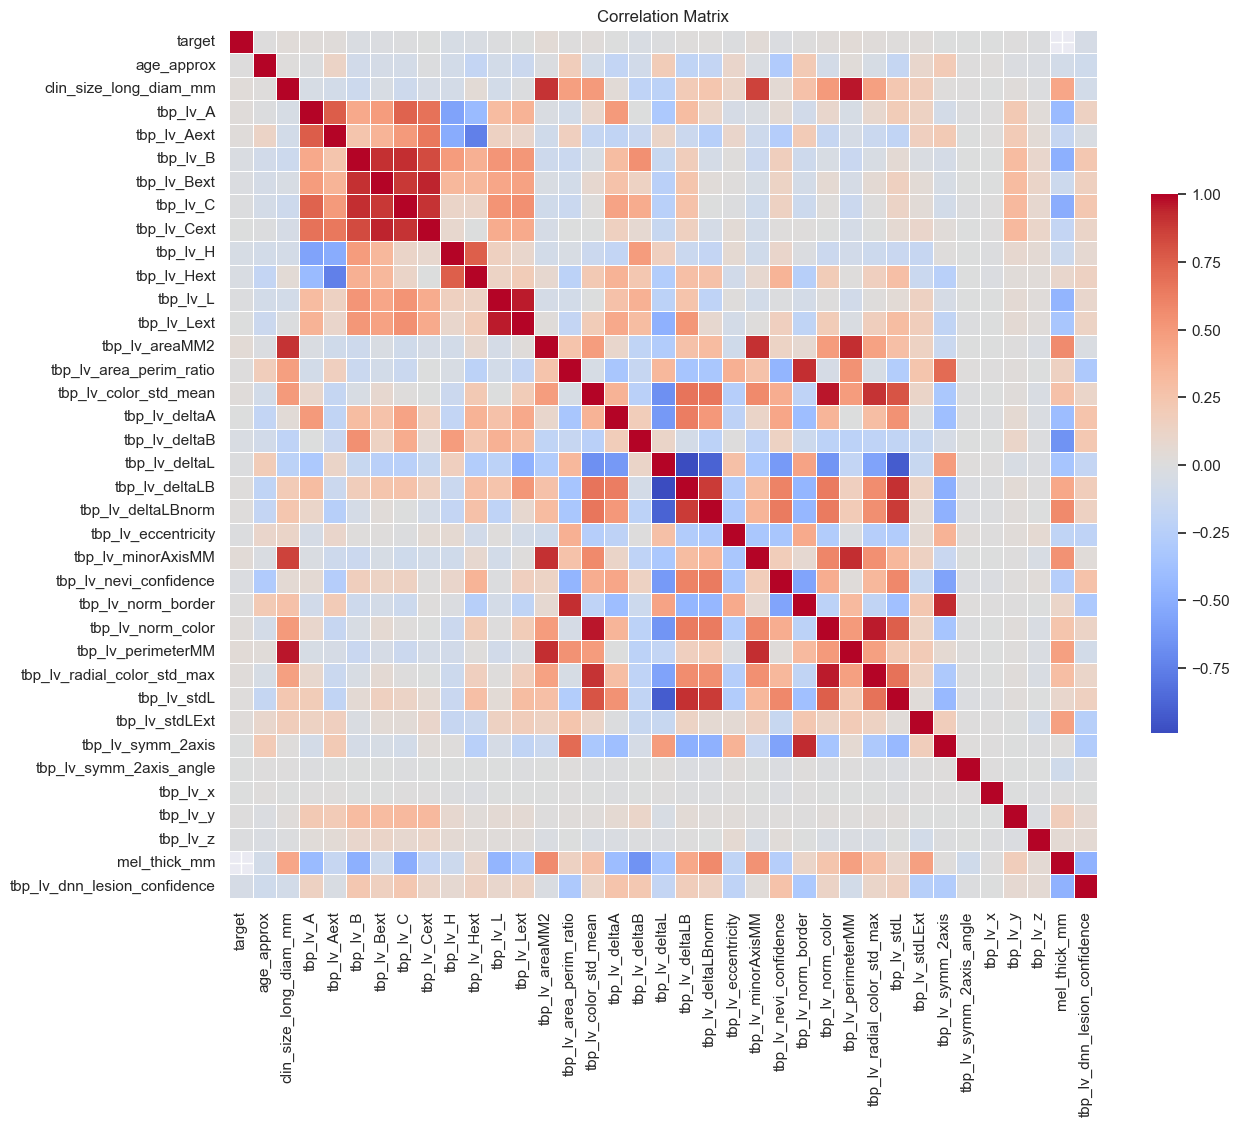

In [34]:
# Calculating the correlation matrix for the numeric data (including some categorical data)
correlation_matrix = train_metadata[numerics].corr()

#Set figure size
plt.figure(figsize=(14, 14))
#Make the heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Matrix')
plt.show()